# Dimensionality Reduction

Dimensionality reduction is a technique used in machine learning and statistics to reduce the number of input variables in a dataset. More input features often make a model more complex, increasing the risk of overfitting and making the model harder to interpret. Dimensionality reduction techniques aim to simplify models without losing much information.

---

### Why is Dimensionality Reduction Important?

1. **Simplification**: Makes the dataset easier to explore and visualize.
2. **Speed**: Reduces the computational complexity, making algorithms run faster.
3. **Data Compression**: Allows for more efficient storage of data.
4. **Noise Reduction**: Helps to eliminate irrelevant features or reduce noise.
5. **Improved Performance**: Can lead to better model performance when irrelevant features are removed.

---

### Example: Customer Segmentation in Retail

Imagine you're a data scientist at a retail company. The company collects data on customer transactions, online activity, customer service interactions, and more. In total, you have hundreds of features for each customer.

**The Problem**: You want to segment your customer base to target marketing more effectively, but the high dimensionality of your data makes it difficult to gain any meaningful insights.

**The Solution**: By applying dimensionality reduction techniques like PCA, you can reduce your hundreds of features to just a few principal components. These components can effectively summarize the essential information in the dataset, making it easier to perform customer segmentation.

**Outcome**: The marketing team can now more effectively tailor strategies for different segments, thereby increasing customer engagement and revenue.

## Overview

1. The curse of dimensionality
2. PCA
3. Factor Analysis
4. Adaptive Methods: t-SNE and UMAP
5. Other techniques and resources

---

# The Curse of Dimensionality

 In high dimensions, the behavior of data can be counterintuitive, and algorithms that work well in low dimensions can become ineffective or computationally expensive.  This is because the available "space" that training samples are embedded grows exponentially with respect to the data.  This has several ramifications:

 - Distances between items become larger
 - Difference between distances become smaller
 - The amount of data required to cover the space grows exponentially

### The Hughes Phenomenon ###

In the late 70’s, G. Hughes observed a strange phonomenon while observing large datasets. It is best summarized by the picture below. 

![The Hughes Phenomenon](./assets/hughes_phenomenon.png)

Intuitively, it would be easy to understand that the more inputs (features) you provide the model, the more the predictive power of the model. However, after a certain point the accuracy of the prediction drops off. This is the essence of Hughes Phenomonon. It is based on the fact that measuring data (features or variables) typically has some level of error to it. When you compound this error over a large number of variables, the error explodes so much that the accuracy is affected.

See [this explanation](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) to help guide your intuitions.

---

### Experiments with dimensionality

The following code illustrates how increasing dimensionality increases distance.

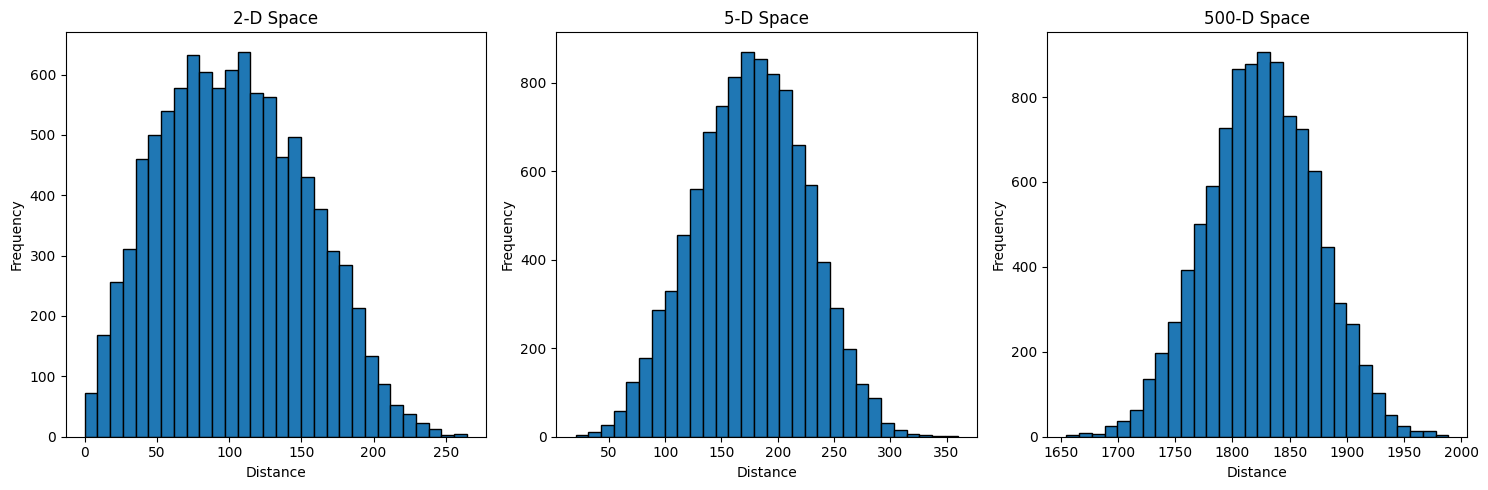

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(num_points, num_dimensions):
    return[np.random.randint(-100, 100, num_dimensions) for _ in range(num_points)]

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_pairwise_distances(points_x,points_y):
    distances = []
    for i,j in zip(points_x,points_y):
        distances.append(euclidean_distance(i,j))
    return np.array(distances)

# Set the number of points and dimensions
num_points = 10000

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through a few different dimensions
for ax, num_dimensions in zip(axes, [2, 5, 50]):
    # Generate points in unit hypercube
    points_x = generate_points(num_points, num_dimensions)
    points_y = generate_points(num_points, num_dimensions)

    # Compute pairwise distances
    distances = compute_pairwise_distances(points_x,points_y)
    
    # Plot histogram of distances
    ax.hist(distances, bins=30, edgecolor='black')
    ax.set_title(f"{num_dimensions}-D Space")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Exercise

1. Can you create a loop and evaluate the mean distance for dimensions from 0 - 500? 

---

###

However, observe that the relative differences between max an min in fact approach zero!

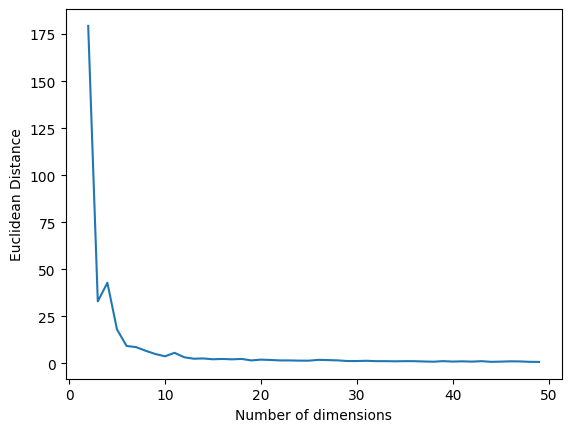

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = (mxd-mnd)/mnd
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Euclidean Distance')
plt.show()

---
# Principle Components Analysis (PCA)

One way to reduce dimensionality is a principle components analysis (PCA).  PCA works by performing an eigenvector/eigenvalue decomposition of the data's covariance matrix. The goal is to transform the original features into a new set of uncorrelated features, known as principal components, which capture as much of the data's variance as possible. The first few principal components typically capture the majority of the variance, allowing for a lower-dimensional representation of the data.

### How does it work?

1. Center the data around the origin by subtracting the mean of each feature from the data points.

2. Calculate the covariance matrix, which captures how each feature varies with every other feature.

3. Compute the eigenvalues and eigenvectors of this covariance matrix. An eigenvector of a square matrix $A$ is a non-zero vector $\mathbf{v}$ that, when the matrix multiplies it, only scales the vector and does not change its direction. Mathematically, this can be written as $A\mathbf{v} = \lambda \mathbf{v}$

   Here, $A$ is the square matrix, $\mathbf{v}$ is the eigenvector, and $\lambda$ is the eigenvalue corresponding to this eigenvector. The eigenvalue controls how much the eigenvector is scaled. 
   
   **Intuition**: Imagine you have a rubber sheet that you can stretch, compress, or rotate. If you put an arrow (vector) on this sheet and then transform the sheet, most arrows would change both direction and length. However, some special arrows (eigenvectors) would only get "stretched" or "compressed" — they wouldn't change direction. The amount by which they get stretched or compressed is the eigenvalue. 

4. Eigenvalues are sorted in descending order, and the eigenvectors are rearranged correspondingly. The first eigenvalue will be the largest and indicates the maximum variance in the data that the first principal component (the corresponding eigenvector) captures.

5. To reduce dimensions, you can now select the first $k$ eigenvectors, where $k$ is the number of dimensions you want in your reduced dataset. You then project your original, centered data into this new \(k\)-dimensional subspace.

6. You can approximate the original data from the reduced data by projecting it back onto the original high-dimensional space by multiplying (dot-product) the transformed data with the transpose of the reduced eigenvector matrix.

### A Simple Example

First, we'll set up some sample data

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 2D data
np.random.seed(0)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T

Now, the PCA, and the reconstruction:

In [17]:

# Step 2: Apply PCA and plot the rotated data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 3: Apply PCA and plot the rotated data
X_reduced = PCA(n_components=1).fit_transform(X)
X_reconstructed = PCA(n_components=1).fit(X).inverse_transform(X_reduced)


Finally, plotting:

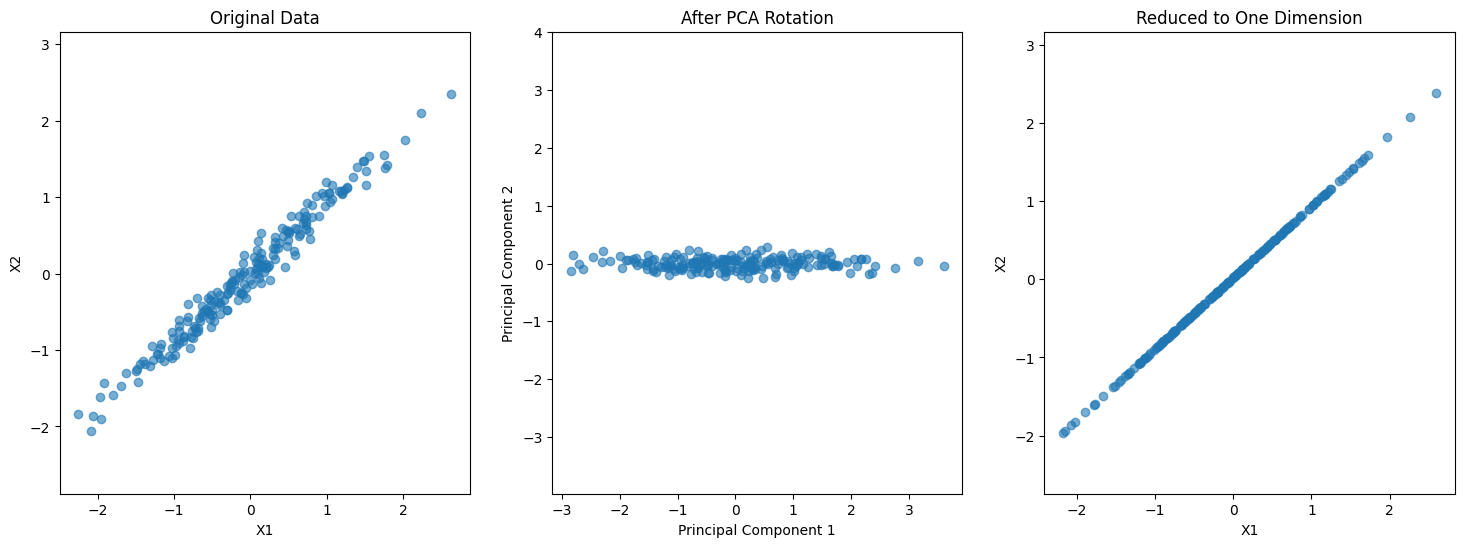

In [18]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.title("Original Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')



plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("After PCA Rotation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6)
plt.title("Reduced to One Dimension")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis('equal')

plt.show()

### Selecting the right number of components

To select the right number of components, we can use the eigenvalues to calculate the amount of variance explained.  The variance explained by each principal component is directly related to the eigenvalues of the covariance matrix of the original dataset. Specifically, the proportion of variance explained by the $i^{th}$ principal component is given by:

$$
\text{Variance Explained}_i = \frac{\lambda_i}{\sum_{j=1}^{n} \lambda_j}
$$

where $\lambda_i$ is the eigenvalue corresponding to the $i^{th}$ principal component and $n$ is the number of components.

The eigenvalues are stored in decreasing order, and they measure the amount of variance along each principal component. A larger eigenvalue indicates that more variance is explained by that principal component.  We can visualize variance explained using a scree plot, and use the "elbow" method to select the number of components.

Variance Explained per Principal Component: [7.92556233e-01 7.41478585e-02 5.24005453e-02 3.51199136e-02
 2.11433667e-02 1.56168523e-02 4.84778213e-03 2.69208636e-03
 1.29776686e-03 1.77595141e-04]


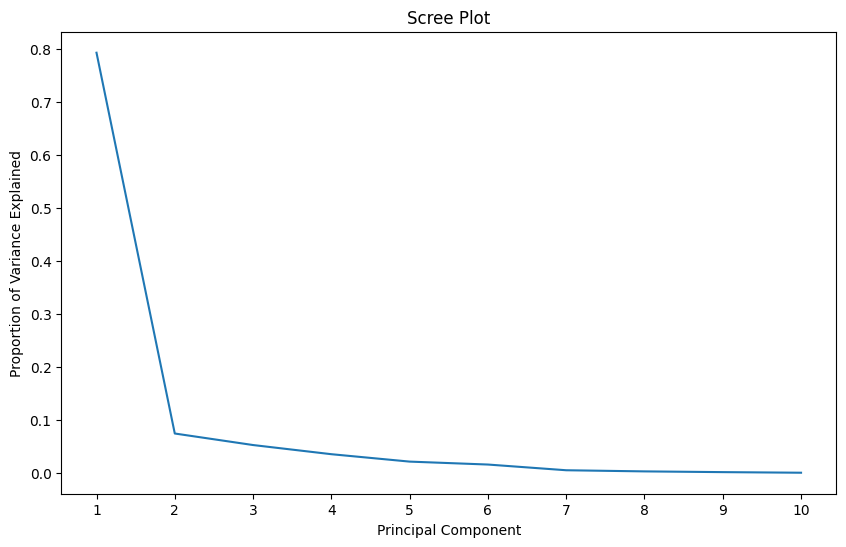

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Create synthetic 10D data
np.random.seed(0)
X_high_dim = np.dot(np.random.rand(10, 10), np.random.randn(10, 200)).T

# Step 2: Apply PCA
pca_high_dim = PCA()  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim = pca_high_dim.fit_transform(X_high_dim)

# Step 3: Calculate Variance Explained
variance_explained = pca_high_dim.explained_variance_ratio_
print("Variance Explained per Principal Component:", variance_explained)

# Step 4: Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.xticks(range(1, len(variance_explained) + 1))
plt.show()

Alternatively, if you know how much variance you want to explain, you can easily calculate it like this:

In [24]:
# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(pca_high_dim.explained_variance_ratio_)

# Find the number of components for desired explained variance
threshold = 0.95  # 95% variance
n_components = np.argmax(cumulative_variance_explained >= threshold) + 1
print(f"Number of components needed for {threshold*100}% variance: {n_components}")

Number of components needed for 95.0% variance: 4


Scikit learn also let's you specify the variance you want in advance and will automatically lift out the number of components you need.

In [25]:
pca_high_dim = PCA(threshold)  # although you can specify n_components, leaving out this parameter returns all
X_pca_high_dim_auto = pca_high_dim.fit_transform(X_high_dim)

print(f"Number of components retrieved for {threshold*100}% = {X_pca_high_dim_auto.shape[1]}")

Number of components retrieved for 95.0% = 4


## Exercise 2

The MNIST data contains a large sample of handwritten letters.  Each letter is a 28x28 (768) grid of pixels, so the data is quite high dimensional.  Try using PCA to visualize the data.  I'll get you started with a little code below/

In [16]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Visualize using PCA (2 components)
# Reduce the data with PCA

# You need to populate the following variable
X__mnist_reduced = None

pca = PCA(n_components=2)
X_mnist_reduced = pca.fit_transform(X_mnist_train)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


: 

: 

In [ ]:
# Now plotting
plt.figure(figsize=(15,15))
plt.scatter(X_mnist_reduced[:, 0], X_mnist_reduced[:, 1], c=y_train, cmap="jet",s=5)
plt.colorbar()
plt.title("MNIST - 2D PCA")
plt.show()

Now the scree plot...

In [ ]:

# Step 3: Scree Plot
pca_scree = None # What goes here???
# How do you get variance explained?
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Scree Plot")
plt.show()


Choose the number of components to achieve 95% variance:

In [ ]:

# Step 4: Number of components for 95% variance
threshold = 0.95
n_components = None # What goes here???
print(f"Number of components for {threshold*100}% variance: {n_components}")

It's interesting to look at how a transform and reconstruction affects a single MNIST digit.  I've written a function to display a single digit.  Use PCA and the reconstruction method to have a look at this.  

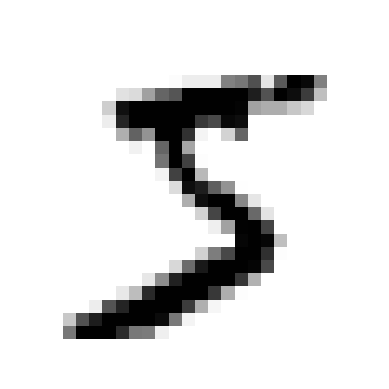

In [7]:
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X[0])

In [ ]:
# Use PCA with n_components to transform the above digit.  How does it look?

Use `n_components` to train a KNNClassifier, and compare accuracy to the non-reduced data.

In [ ]:
# Step 5: k-NN Classification
# Without PCA
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

# With PCA
# You have some work to do right here


y_pred_pca = None # How do you do this?
print(f"PCA-transformed Data Accuracy: {accuracy_score(y_test, y_pred_pca)}")


---

## Limitations of PCA

One of the key limitations of PCA is that it is a linear technique. This means that it works by finding new axes, called principal components, that are linear combinations of the original features. These principal components aim to capture as much variance in the data as possible. However, the linear nature of PCA imposes a limitation: it struggles to capture patterns in data that are fundamentally non-linear.

Imagine a dataset where points are distributed in a non-linear fashion, like a spiral or concentric circles. A linear method like PCA would not be able to capture the essence of such patterns. This is because the concept of "distance" or "variance" that PCA relies on does not adequately describe the intrinsic geometry of the data.

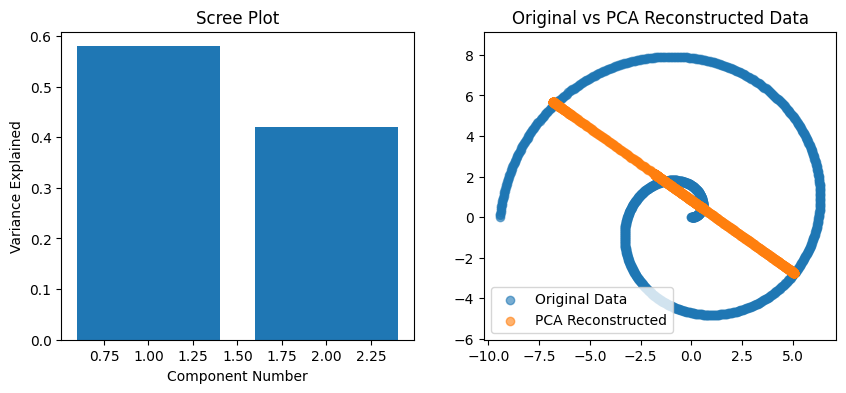

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate synthetic spiral data
n_points = 1000
n_turns = 3
t = np.linspace(0, n_turns * np.pi, n_points)
x = t * np.cos(t)
y = t * np.sin(t)

X_spiral = np.column_stack([x, y])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_spiral)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Variance Explained")

# Original Data vs PCA reconstruction
X_reduced = PCA(n_components=1).fit_transform(X_spiral)
X_reconstructed = PCA(n_components=1).fit(X_spiral).inverse_transform(X_reduced)

plt.subplot(1, 2, 2)
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], alpha=0.6, label='Original Data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.6, label='PCA Reconstructed')
plt.legend()
plt.axis('equal')
plt.title("Original vs PCA Reconstructed Data")

plt.show()


---

# Other Approaches

There are many many approach to dimesionality reduction.  Several extensions to PCA address it's limitations and extend it's capabilities.  One of these is **Kernel PCA**.

### Kernel PCA

Kernel Principal Component Analysis (Kernel PCA) is an extension of the standard Principal Component Analysis (PCA), designed to handle non-linear data effectively. While standard PCA works by finding linear principal components to project data onto, Kernel PCA works in an implicitly defined higher-dimensional feature space where these projections can be non-linear.

### How Kernel PCA Works

1. **Feature Space Mapping**: First, each data point in the original space is mapped into a higher-dimensional feature space using a kernel function $K(x_i, x_j)$. We'll talk about kernel functions a lot more when we get to **Support Vector Machines**.

2. **Principal Component Analysis in Feature Space**: In this new feature space, the regular PCA algorithm is applied. Since working in a higher-dimensional space can be computationally intensive, Kernel PCA cleverly utilizes the "kernel trick" to compute principal components in the feature space without explicitly working in it.

3. **Projecting Data**: Finally, the original data is projected onto these new principal components in the feature space. The resulting data can be linearly separable even if the original data was not.

### Kernel Functions

Kernel PCA relies on the use of a kernel function to compute the similarity between pairs of data points in the feature space. Popular choices for kernel functions include:

- **Polynomial Kernel**: $K(x_i, x_j) = (x_i \cdot x_j + c)^d$
- **RBF (Radial Basis Function) or Gaussian Kernel**: $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$
- **Sigmoid Kernel**: $K(x_i, x_j) = \tanh(\alpha x_i \cdot x_j + c)$

### Advantages and Limitations

#### Advantages
- Can capture complex, non-linear relationships in data.
- Suitable for clustering, classification, and other tasks where linear methods fail.

#### Limitations
- Computationally more expensive compared to standard PCA.
- Requires choosing an appropriate kernel function and tuning its parameters, which may not be straightforward.

#### Example

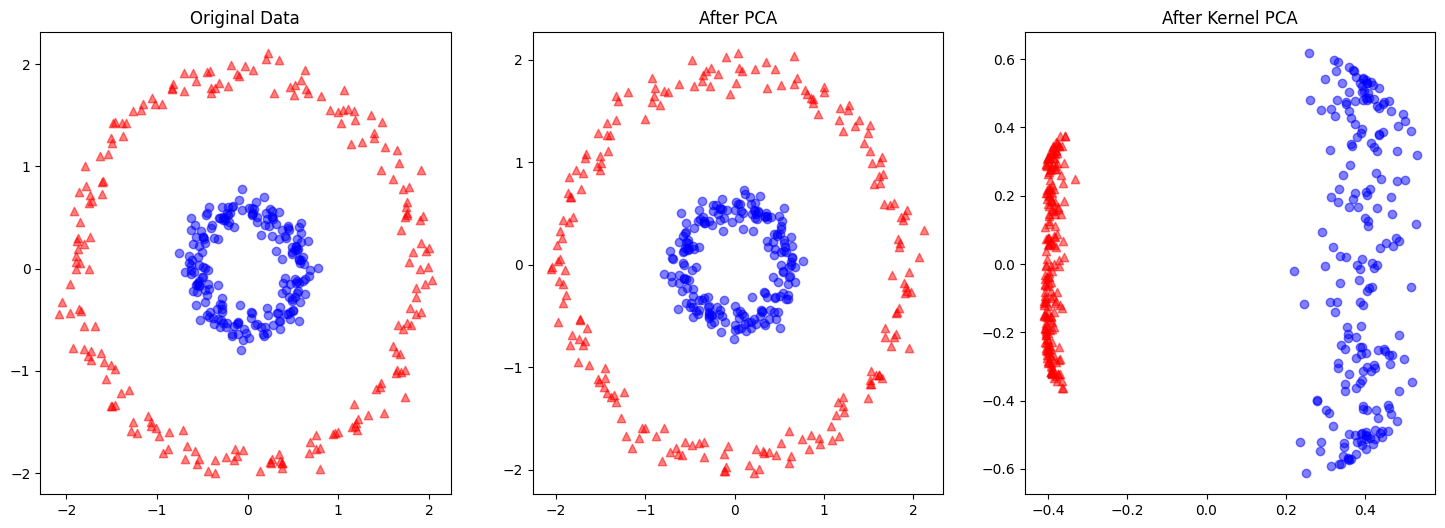

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic data for concentric circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply regular PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Apply Kernel PCA with Radial Basis Function (RBF) kernel
kpca = KernelPCA(kernel="rbf", gamma=1, n_components=2)
X_kpca = kpca.fit_transform(X_std)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot original data
axes[0].scatter(X_std[y == 0, 0], X_std[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[0].scatter(X_std[y == 1, 0], X_std[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[0].set_title("Original Data")

# Plot data transformed by PCA
axes[1].scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[1].scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[1].set_title("After PCA")

# Plot data transformed by Kernel PCA
axes[2].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
axes[2].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
axes[2].set_title("After Kernel PCA")

plt.show()

# Adaptive Techniques

Adaptive techniques seek to preserve complex, non-linear relationships between data points. Unlike linear methods like PCA, which apply a rigid transformation to all points in the dataset equally, adaptive methods tweak and optimize the transformation for different regions of the data space. In simpler terms, they adapt to the underlying data distribution.

This adaptability often makes these techniques more suitable for capturing and preserving intricate structures in high-dimensional data, such as clusters or manifolds.  However, they are often stochastic and are not guaranteed to preserve distances in the transformed data, so may not be suitable in all cases.  They are, however, excellent for visualization and some kinds of classification problems.


## t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is particularly effective for visualizing high-dimensional data in 2D or 3D.
 
#### How it Works:

1. **Probability Distributions**: t-SNE starts by calculating the pairwise similarities between points in the high-dimensional space and in the low-dimensional space. These similarities are converted into conditional probabilities that a point would pick another point as its neighbor if neighbors were picked in proportion to their similarity.

2. **Minimize the Divergence**: t-SNE aims to minimize the difference between these two probability distributions for the high-dimensional and low-dimensional spaces. Specifically, it minimizes the Kullback-Leibler divergence between them.

3. **t-Distribution**: To calculate the similarity between points in the low-dimensional space, t-SNE uses a t-distribution, which has heavier tails compared to a normal distribution. This allows t-SNE to be particularly sensitive to local structures.

#### Strengths:

- Excellent at preserving local cluster structures.
- Particularly useful for visualization.

#### Weaknesses:

- Computationally intensive.
- May not preserve global structures well.
- The results are sensitive to hyperparameters like perplexity and the learning rate.

t-SNE has been a popular choice for tasks like visualizing gene expression data, understanding neural network activations, clustering, and much more.

With t-SNE, it's easier to capture the non-linear manifolds and groupings in data, making it an excellent tool for exploratory data analysis. However, because it's computationally demanding and somewhat unpredictable, it may not always be the best choice for all types of dimensionality reduction tasks.

---

### Example

A classic example of data that PCA struggles with is the `swiss role`, which you can envision as a sheet of paper rolled into a tube.  You'll see the PCA manages to uncover the spiral, but not it's "sheet-like" properties.

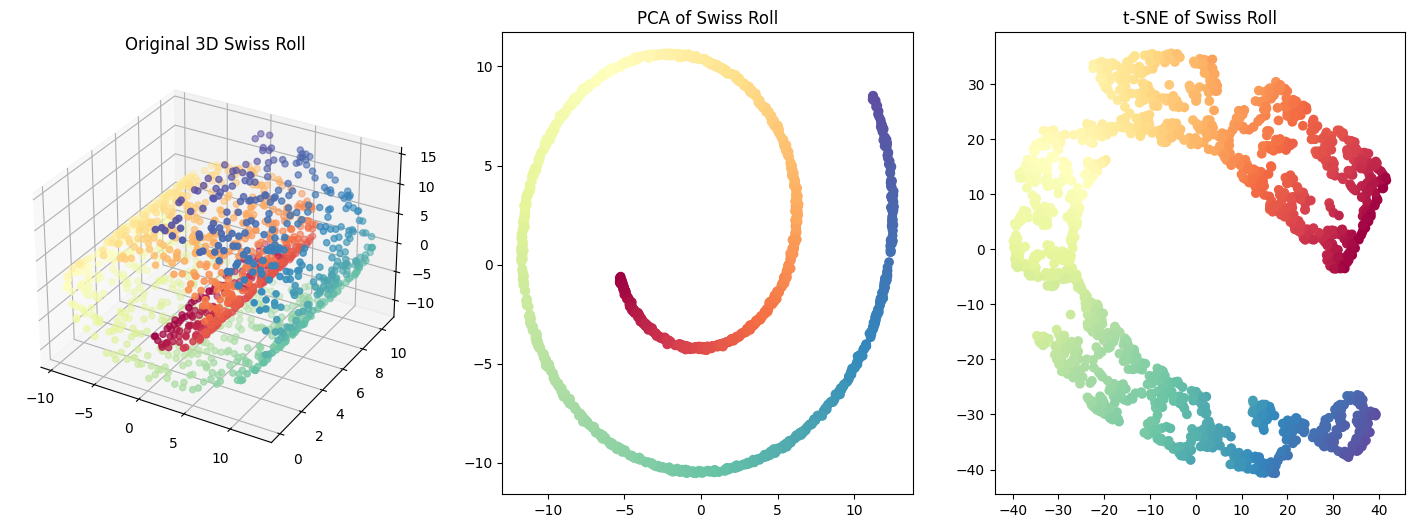

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Create Swiss Roll data
n_samples = 1500
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualization
fig = plt.figure(figsize=(18, 6))

# 3D Swiss Roll
ax0 = fig.add_subplot(131, projection='3d')
ax0.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax0.set_title("Original 3D Swiss Roll")

# PCA
ax1 = fig.add_subplot(132)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=plt.cm.Spectral)
ax1.set_title("PCA of Swiss Roll")

# t-SNE
ax2 = fig.add_subplot(133)
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.Spectral)
ax2.set_title("t-SNE of Swiss Roll")

plt.show()


## Exercise 3

Try using t-SNE to visualize the MNIST data above.  How does it compare to PCA?